In [26]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import boto3
from sagemaker import get_execution_role
import sagemaker
%matplotlib inline

In [30]:
bucket = 'arch-ml-bucket-us-east-1'
role = get_execution_role()

with open('centroids.optimal.pkl', 'rb') as f:
    centroids = pickle.load(f)
    
with open('model_info.optimal.txt', 'r') as f:
    [model_key, image_name] = f.read().split('\n')
    
with open('feature_list.txt', 'r') as f:
    features = f.read()
    features = features.split(',')
    
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(file=f)
    
data_to_cluster = pd.read_csv('Mall_Customers.csv')

def get_model(model_key, image_name):
    sess = sagemaker.Session()
    model = sagemaker.model.Model (
        model_data = 's3://{}/{}'.format(bucket, model_key),
        image = image_name,
        role = role,
        sagemaker_session = sess)
    return model

model = get_model(model_key, image_name)

# Explore Customer Segments

In [10]:
cluster_df = pd.DataFrame(
    columns=features,
    data=list(map(lambda c: scaler.inverse_transform(c), centroids))
)

print('            Customer Segments\n')
print(cluster_df)

            Customer Segments

   Annual Income (k$)  Spending Score (1-100)
0           85.530609               81.877548
1           53.867348               50.438774
2           87.065216               18.260872
3           25.037035               79.074074
4           26.133333               19.133335


# Cluster The Data (Predict)

In [32]:
# Deploy Model To Endpoint
endpoint_name = 'kmeans-mall-v2'
model.deploy(initial_instance_count = 1, 
             instance_type = 'ml.t2.medium', 
             endpoint_name=endpoint_name)

INFO:sagemaker:Creating model with name: kmeans-2019-05-08-07-10-27-393
INFO:sagemaker:Creating endpoint with name kmeans-mall-v2


---------------------------------------------------------------------------------------------------------------------------!

In [34]:
from sagemaker.predictor import csv_serializer, json_deserializer

# Acquire endpoint to make prediction
predictor = sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name)

predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer
predictor.deserializer = None

In [56]:
import json

preds = predictor.predict(scaler.transform(data_to_cluster[features]))
preds = preds.decode('utf-8')
preds = json.loads(preds)['predictions']

In [58]:
data_to_cluster['cluster'] = list(map(lambda x: x['closest_cluster'], preds))

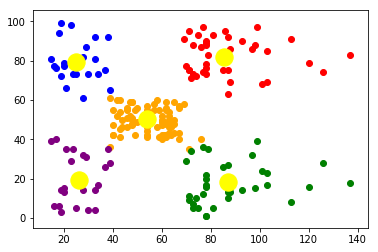

In [63]:
for i, c in enumerate(['red', 'orange', 'green', 'blue', 'purple']):
    filtered = data_to_cluster[data_to_cluster['cluster'] == i]
    plt.scatter(x=filtered[features[0]],
               y=filtered[features[1]],
               c=c)
    
plt.scatter(
    list(map(lambda c: c[0], scaler.inverse_transform(centroids))), 
    list(map(lambda c: c[1], scaler.inverse_transform(centroids))), 
            s = 300, c = 'yellow', label = 'Centroids')

# Delete the endpoint after use

In [64]:
predictor.delete_endpoint(delete_endpoint_config=False)

INFO:sagemaker:Deleting endpoint with name: kmeans-mall-v2
